In [1]:
"""
Multiple Correspondence Analysis (MCA) - Obesity Dataset
Approach 1: Transform quantitative variables to categorical

This notebook performs MCA on categorical variables including discretized
quantitative variables (Age and Weight).
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")

In [2]:
# Load data
df = pd.read_csv("dataset/obesity.csv")

# Select variables
categorical_vars = [
    "Gender",
    "family_history_with_overweight",
    "FAVC",
    "CAEC",
    "MTRANS",
]

quantitative_vars = ["Age", "Weight"]
target_var = "NObeyesdad"

# Extract subset
df_subset = df[categorical_vars + quantitative_vars + [target_var]].copy()

print(f"Dataset: {len(df_subset)} observations")
print(
    f"Variables: {len(categorical_vars)} categorical + {len(quantitative_vars)} quantitative"
)

Dataset: 2111 observations
Variables: 5 categorical + 2 quantitative


In [3]:
# Descriptive statistics
print("\nCategorical variables:")
for var in categorical_vars:
    print(f"\n{var}:")
    counts = df_subset[var].value_counts()
    for category, count in counts.items():
        print(f"  {category}: {count} ({count/len(df_subset)*100:.1f}%)")

print("\nQuantitative variables:")
print(df_subset[quantitative_vars].describe().round(2))


Categorical variables:

Gender:
  Male: 1068 (50.6%)
  Female: 1043 (49.4%)

family_history_with_overweight:
  yes: 1726 (81.8%)
  no: 385 (18.2%)

FAVC:
  yes: 1866 (88.4%)
  no: 245 (11.6%)

CAEC:
  Sometimes: 1765 (83.6%)
  Frequently: 242 (11.5%)
  Always: 53 (2.5%)
  no: 51 (2.4%)

MTRANS:
  Public_Transportation: 1580 (74.8%)
  Automobile: 457 (21.6%)
  Walking: 56 (2.7%)
  Motorbike: 11 (0.5%)
  Bike: 7 (0.3%)

Quantitative variables:
           Age   Weight
count  2111.00  2111.00
mean     24.31    86.59
std       6.35    26.19
min      14.00    39.00
25%      19.95    65.47
50%      22.78    83.00
75%      26.00   107.43
max      61.00   173.00


In [4]:
# Transform quantitative to categorical
df_categorical = df_subset[categorical_vars].copy()

# Age: 3 groups
age_bins = [0, 25, 40, 100]
age_labels = ["Young (≤25)", "Adult (26-40)", "Senior (>40)"]
df_categorical["Age_Cat"] = pd.cut(
    df_subset["Age"], bins=age_bins, labels=age_labels, include_lowest=True
)

# Weight: 3 groups
weight_bins = [0, 65, 85, 200]
weight_labels = ["Light (<65kg)", "Medium (65-85kg)", "Heavy (>85kg)"]
df_categorical["Weight_Cat"] = pd.cut(
    df_subset["Weight"], bins=weight_bins, labels=weight_labels, include_lowest=True
)

print("\nCategorical transformation:")
print(f"Age groups:\n{df_categorical['Age_Cat'].value_counts().sort_index()}")
print(f"\nWeight groups:\n{df_categorical['Weight_Cat'].value_counts().sort_index()}")


Categorical transformation:
Age groups:
Age_Cat
Young (≤25)      1369
Adult (26-40)     685
Senior (>40)       57
Name: count, dtype: int64

Weight groups:
Weight_Cat
Light (<65kg)       520
Medium (65-85kg)    608
Heavy (>85kg)       983
Name: count, dtype: int64


In [5]:
# Create indicator matrix
df_indicators = pd.get_dummies(df_categorical, drop_first=False, dtype=int)
print(
    f"\nIndicator matrix: {df_indicators.shape[0]} rows × {df_indicators.shape[1]} columns"
)

# Standardize indicator matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_indicators)

# Apply MCA (PCA on indicator matrix)
n_components = 10
mca = PCA(n_components=n_components)
X_mca = mca.fit_transform(X_scaled)


Indicator matrix: 2111 rows × 21 columns


In [6]:
# Benzécri correction
# Correct eigenvalues for MCA bias due to categorical coding
J = len(df_indicators.columns)  # Number of categories
K = len(df_categorical.columns)  # Number of variables

print(f"\nApplying Benzécri correction:")

eigenvalues_original = mca.explained_variance_.copy()

# Apply correction: λ_corrected = ((K/(K-1)) * (√λ - 1/K))²
# Only correct eigenvalues > 1/K
eigenvalues_corrected = np.zeros_like(eigenvalues_original)
for i, eigenval in enumerate(eigenvalues_original):
    if eigenval > (1 / K):
        eigenvalues_corrected[i] = ((K / (K - 1)) * (np.sqrt(eigenval) - 1 / K)) ** 2
    else:
        eigenvalues_corrected[i] = 0

# Recalculate variance ratios
total_inertia_corrected = np.sum(eigenvalues_corrected)
explained_variance_ratio_corrected = eigenvalues_corrected / total_inertia_corrected

# Update MCA object
mca.explained_variance_ = eigenvalues_corrected
mca.explained_variance_ratio_ = explained_variance_ratio_corrected

print(f"\nCorrected eigenvalues:")
for i in range(min(5, len(eigenvalues_corrected))):
    print(
        f"  Dim {i+1}: {eigenvalues_original[i]:.4f} → {eigenvalues_corrected[i]:.4f}"
    )

# Variance explained (corrected)
print("\nVariance explained:")
cumulative = 0
for i, var in enumerate(mca.explained_variance_ratio_[:5], 1):
    cumulative += var
    print(f"Dimension {i}: {var*100:.2f}% (cumulative: {cumulative*100:.2f}%)")


Applying Benzécri correction:

Corrected eigenvalues:
  Dim 1: 4.2708 → 5.0372
  Dim 2: 2.5599 → 2.8898
  Dim 3: 2.0370 → 2.2453
  Dim 4: 1.7697 → 1.9192
  Dim 5: 1.5889 → 1.7002

Variance explained:
Dimension 1: 25.73% (cumulative: 25.73%)
Dimension 2: 14.76% (cumulative: 40.48%)
Dimension 3: 11.47% (cumulative: 51.95%)
Dimension 4: 9.80% (cumulative: 61.75%)
Dimension 5: 8.68% (cumulative: 70.44%)


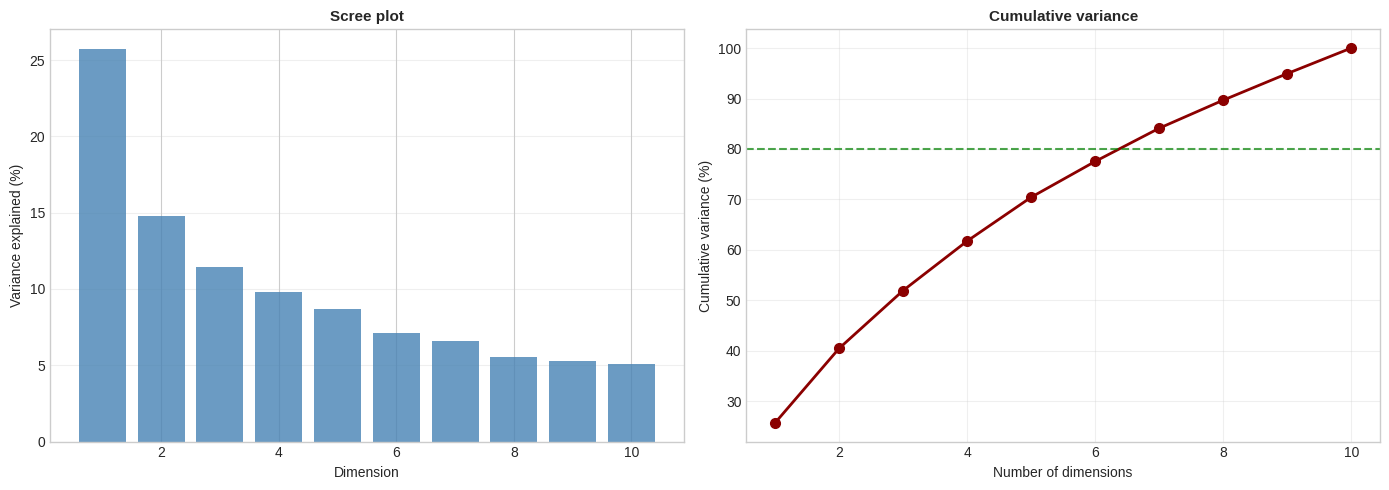

In [7]:
# Scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(
    range(1, n_components + 1),
    mca.explained_variance_ratio_ * 100,
    color="steelblue",
    alpha=0.8,
)
ax1.set_xlabel("Dimension", fontsize=10)
ax1.set_ylabel("Variance explained (%)", fontsize=10)
ax1.set_title("Scree plot", fontsize=11, fontweight="bold")
ax1.grid(axis="y", alpha=0.3)

cumulative = np.cumsum(mca.explained_variance_ratio_ * 100)
ax2.plot(
    range(1, n_components + 1),
    cumulative,
    marker="o",
    linewidth=2,
    markersize=7,
    color="darkred",
)
ax2.axhline(y=80, color="green", linestyle="--", linewidth=1.5, alpha=0.7)
ax2.set_xlabel("Number of dimensions", fontsize=10)
ax2.set_ylabel("Cumulative variance (%)", fontsize=10)
ax2.set_title("Cumulative variance", fontsize=11, fontweight="bold")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("approach1_scree.png", dpi=300, bbox_inches="tight")
plt.show()

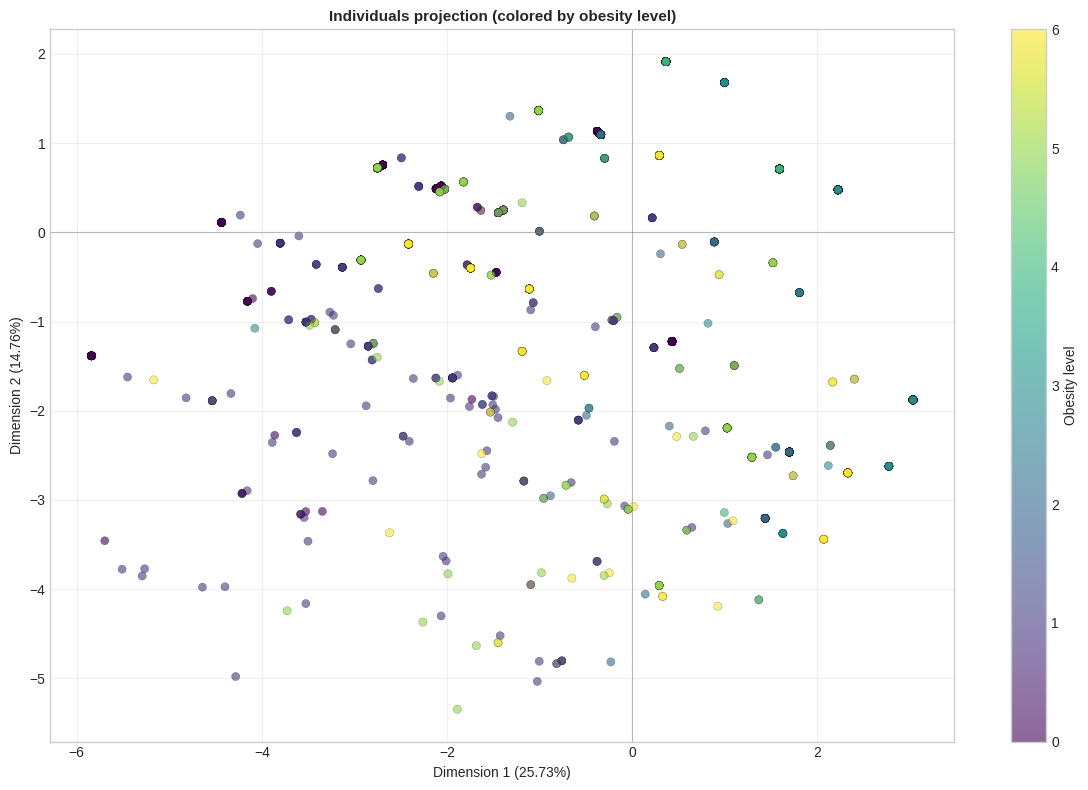

In [8]:
# Individuals projection
fig, ax = plt.subplots(figsize=(12, 8))

obesity_codes = pd.Categorical(df_subset[target_var]).codes
scatter = ax.scatter(
    X_mca[:, 0],
    X_mca[:, 1],
    c=obesity_codes,
    cmap="viridis",
    alpha=0.6,
    s=35,
    edgecolors="k",
    linewidth=0.2,
)

ax.axhline(y=0, color="gray", linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color="gray", linewidth=0.8, alpha=0.5)
ax.set_xlabel(f"Dimension 1 ({mca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=10)
ax.set_ylabel(f"Dimension 2 ({mca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=10)
ax.set_title(
    "Individuals projection (colored by obesity level)", fontsize=11, fontweight="bold"
)
ax.grid(alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Obesity level", fontsize=10)

plt.tight_layout()
plt.savefig("approach1_individuals_projection.png", dpi=300, bbox_inches="tight")
plt.show()

In [9]:
# Categories contributions
loadings = mca.components_.T
contributions_df = pd.DataFrame(
    loadings[:, :3], columns=["Dim1", "Dim2", "Dim3"], index=df_indicators.columns
)

print("\nTop 10 contributors to Dimension 1:")
for cat, contrib in (
    contributions_df["Dim1"].abs().sort_values(ascending=False).head(10).items()
):
    print(f"  {cat}: {contrib:.3f}")

print("\nTop 10 contributors to Dimension 2:")
for cat, contrib in (
    contributions_df["Dim2"].abs().sort_values(ascending=False).head(10).items()
):
    print(f"  {cat}: {contrib:.3f}")


Top 10 contributors to Dimension 1:
  family_history_with_overweight_yes: 0.336
  family_history_with_overweight_no: 0.336
  Weight_Cat_Light (<65kg): 0.323
  Weight_Cat_Heavy (>85kg): 0.312
  CAEC_Sometimes: 0.307
  Age_Cat_Young (≤25): 0.297
  Age_Cat_Adult (26-40): 0.283
  CAEC_Frequently: 0.273
  FAVC_no: 0.225
  FAVC_yes: 0.225

Top 10 contributors to Dimension 2:
  MTRANS_Public_Transportation: 0.525
  MTRANS_Automobile: 0.472
  Age_Cat_Young (≤25): 0.317
  Age_Cat_Adult (26-40): 0.252
  FAVC_no: 0.240
  FAVC_yes: 0.240
  Weight_Cat_Heavy (>85kg): 0.210
  Age_Cat_Senior (>40): 0.208
  Weight_Cat_Medium (65-85kg): 0.179
  MTRANS_Walking: 0.152


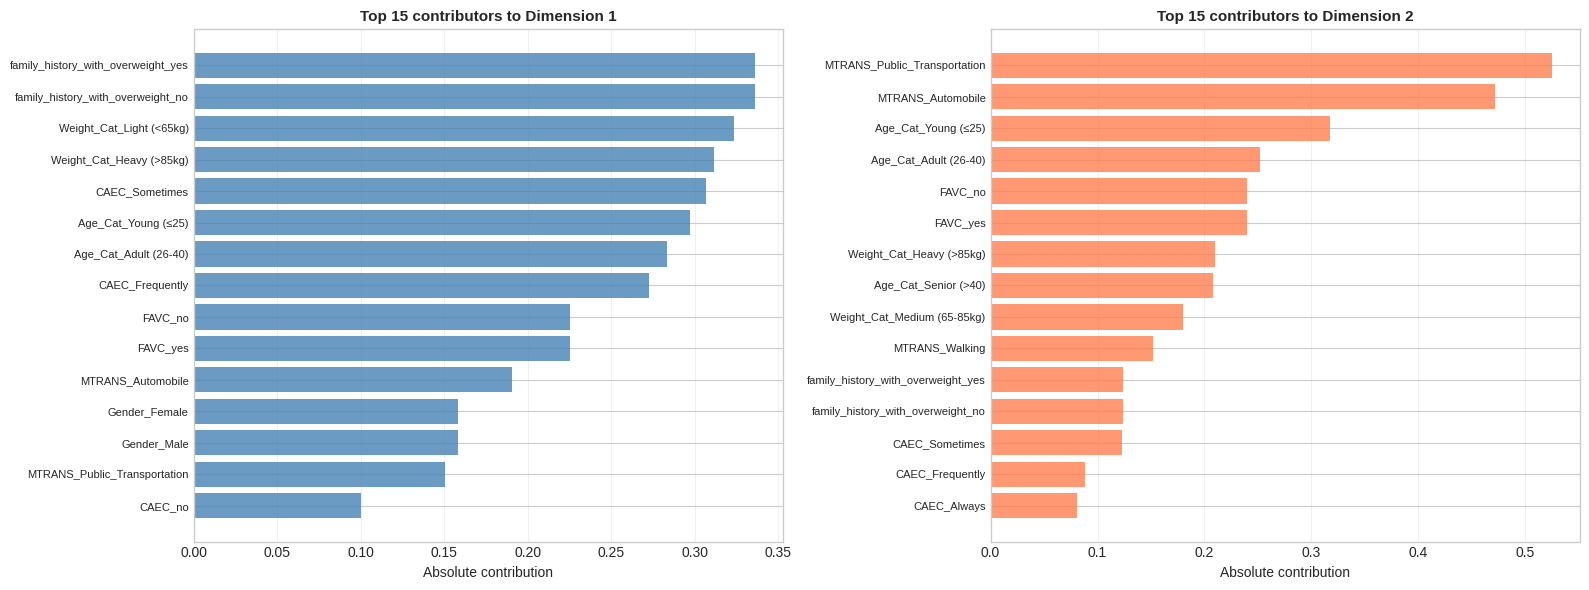

In [10]:
# Categories contributions visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Dimension 1 contributions
top_dim1 = contributions_df["Dim1"].abs().nlargest(15).sort_values()
ax1.barh(range(len(top_dim1)), top_dim1.values, color="steelblue", alpha=0.8)
ax1.set_yticks(range(len(top_dim1)))
ax1.set_yticklabels(top_dim1.index, fontsize=8)
ax1.set_xlabel("Absolute contribution", fontsize=10)
ax1.set_title("Top 15 contributors to Dimension 1", fontsize=11, fontweight="bold")
ax1.grid(axis="x", alpha=0.3)

# Dimension 2 contributions
top_dim2 = contributions_df["Dim2"].abs().nlargest(15).sort_values()
ax2.barh(range(len(top_dim2)), top_dim2.values, color="coral", alpha=0.8)
ax2.set_yticks(range(len(top_dim2)))
ax2.set_yticklabels(top_dim2.index, fontsize=8)
ax2.set_xlabel("Absolute contribution", fontsize=10)
ax2.set_title("Top 15 contributors to Dimension 2", fontsize=11, fontweight="bold")
ax2.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig("approach1_contributions.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
# Category representation quality
category_coords = loadings[:, :3]
category_cos2 = np.zeros_like(category_coords)

for i in range(category_coords.shape[0]):
    total_inertia = np.sum(loadings[i, :] ** 2)
    for j in range(3):
        category_cos2[i, j] = (
            (category_coords[i, j] ** 2) / total_inertia if total_inertia > 0 else 0
        )

cos2_df = pd.DataFrame(
    category_cos2,
    columns=["Cos2_Dim1", "Cos2_Dim2", "Cos2_Dim3"],
    index=df_indicators.columns,
)
cos2_df["Cos2_Dim1+2"] = cos2_df["Cos2_Dim1"] + cos2_df["Cos2_Dim2"]

# Categories well represented on Dim1
print("\nCategories best represented on Dimension 1 (cos² > 0.5):")
well_dim1 = cos2_df[cos2_df["Cos2_Dim1"] > 0.5].sort_values(
    "Cos2_Dim1", ascending=False
)
if len(well_dim1) > 0:
    for cat, cos2 in well_dim1["Cos2_Dim1"].items():
        print(f"  {cat}: {cos2:.3f}")
else:
    print("  None")

# Categories well represented on Dim2
print("\nCategories best represented on Dimension 2 (cos² > 0.5):")
well_dim2 = cos2_df[cos2_df["Cos2_Dim2"] > 0.5].sort_values(
    "Cos2_Dim2", ascending=False
)
if len(well_dim2) > 0:
    for cat, cos2 in well_dim2["Cos2_Dim2"].items():
        print(f"  {cat}: {cos2:.3f}")
else:
    print("  None")

# Categories well represented on first 2 dimensions
print("\nCategories best represented on Dim1+Dim2 (cos² > 0.7):")
well_2d = cos2_df[cos2_df["Cos2_Dim1+2"] > 0.7].sort_values(
    "Cos2_Dim1+2", ascending=False
)
if len(well_2d) > 0:
    for cat, cos2 in well_2d["Cos2_Dim1+2"].items():
        print(f"  {cat}: {cos2:.3f}")
else:
    print("  None")

# Categories poorly represented on first 2 dimensions
print("\nCategories poorly represented on Dim1+Dim2 (cos² < 0.3):")
poorly = cos2_df[cos2_df["Cos2_Dim1+2"] < 0.3].sort_values("Cos2_Dim1+2")
for cat, cos2 in poorly["Cos2_Dim1+2"].head(10).items():
    print(f"  {cat}: {cos2:.3f}")


Categories best represented on Dimension 1 (cos² > 0.5):
  None

Categories best represented on Dimension 2 (cos² > 0.5):
  MTRANS_Public_Transportation: 0.709
  MTRANS_Automobile: 0.626

Categories best represented on Dim1+Dim2 (cos² > 0.7):
  MTRANS_Public_Transportation: 0.767
  MTRANS_Automobile: 0.728

Categories poorly represented on Dim1+Dim2 (cos² < 0.3):
  MTRANS_Motorbike: 0.007
  MTRANS_Bike: 0.008
  CAEC_Always: 0.016
  CAEC_no: 0.025
  MTRANS_Walking: 0.047
  Gender_Male: 0.062
  Gender_Female: 0.062
  Weight_Cat_Medium (65-85kg): 0.063
  Age_Cat_Senior (>40): 0.150
  CAEC_Frequently: 0.154


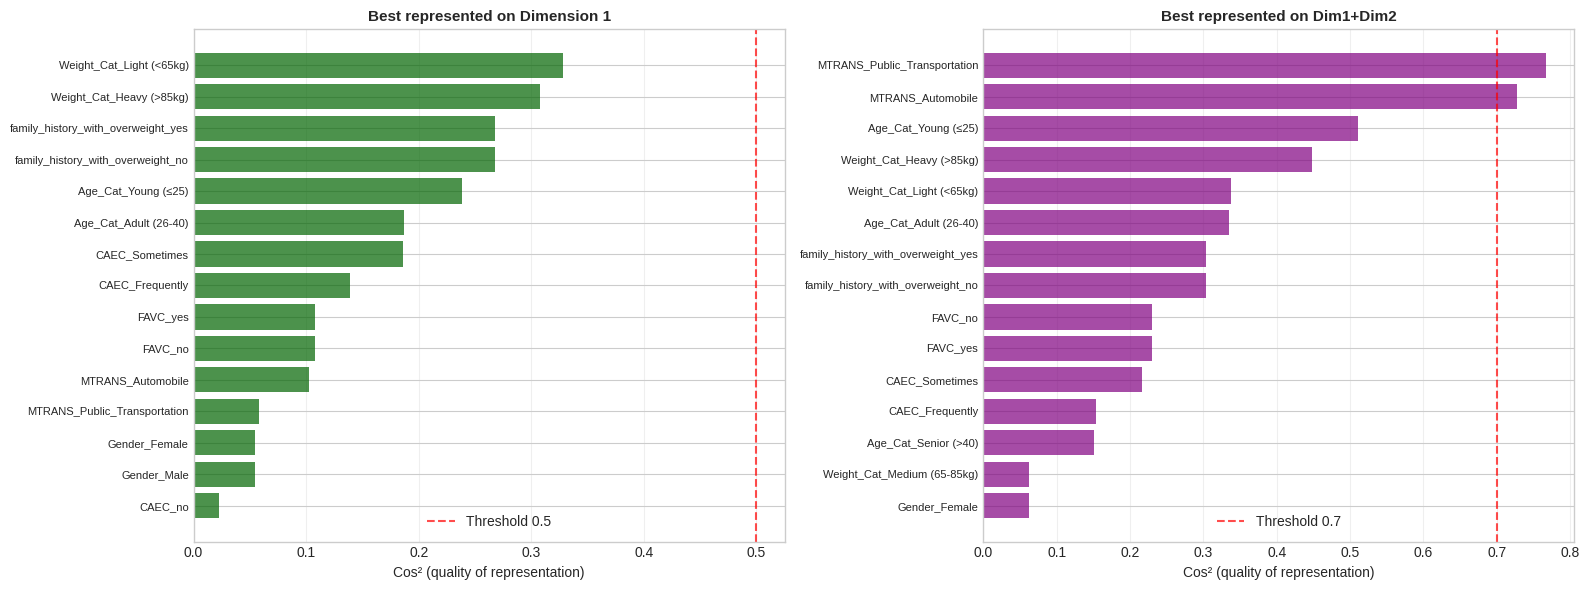

In [12]:
# Categories quality of representation (cos²) visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 by Dim1 cos²
top_cos2_dim1 = cos2_df["Cos2_Dim1"].nlargest(15).sort_values()
ax1.barh(range(len(top_cos2_dim1)), top_cos2_dim1.values, color="darkgreen", alpha=0.7)
ax1.set_yticks(range(len(top_cos2_dim1)))
ax1.set_yticklabels(top_cos2_dim1.index, fontsize=8)
ax1.set_xlabel("Cos² (quality of representation)", fontsize=10)
ax1.set_title("Best represented on Dimension 1", fontsize=11, fontweight="bold")
ax1.axvline(
    x=0.5, color="red", linestyle="--", linewidth=1.5, alpha=0.7, label="Threshold 0.5"
)
ax1.grid(axis="x", alpha=0.3)
ax1.legend()

# Top 15 by Dim1+Dim2 cos²
top_cos2_2d = cos2_df["Cos2_Dim1+2"].nlargest(15).sort_values()
ax2.barh(range(len(top_cos2_2d)), top_cos2_2d.values, color="purple", alpha=0.7)
ax2.set_yticks(range(len(top_cos2_2d)))
ax2.set_yticklabels(top_cos2_2d.index, fontsize=8)
ax2.set_xlabel("Cos² (quality of representation)", fontsize=10)
ax2.set_title("Best represented on Dim1+Dim2", fontsize=11, fontweight="bold")
ax2.axvline(
    x=0.7, color="red", linestyle="--", linewidth=1.5, alpha=0.7, label="Threshold 0.7"
)
ax2.grid(axis="x", alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("approach1_categories_quality.png", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
# Individual representation quality
individual_coords = X_mca[:, :3]
individual_cos2 = np.zeros_like(individual_coords)

for i in range(individual_coords.shape[0]):
    total_inertia = np.sum(X_mca[i, :] ** 2)
    for j in range(3):
        individual_cos2[i, j] = (
            (individual_coords[i, j] ** 2) / total_inertia if total_inertia > 0 else 0
        )

individual_cos2_sum = individual_cos2[:, 0] + individual_cos2[:, 1]

print("\nIndividual representation quality:")
well_count = np.sum(individual_cos2_sum > 0.7)
moderate_count = np.sum((individual_cos2_sum > 0.4) & (individual_cos2_sum <= 0.7))
poor_count = np.sum(individual_cos2_sum <= 0.4)

print(
    f"  Well-represented (cos² > 0.7): {well_count} ({well_count/len(individual_cos2_sum)*100:.1f}%)"
)
print(
    f"  Moderately represented (0.4 < cos² ≤ 0.7): {moderate_count} ({moderate_count/len(individual_cos2_sum)*100:.1f}%)"
)
print(
    f"  Poorly represented (cos² ≤ 0.4): {poor_count} ({poor_count/len(individual_cos2_sum)*100:.1f}%)"
)
print(f"  Mean cos² (Dim1+Dim2): {individual_cos2_sum.mean():.3f}")
print(f"  Median cos² (Dim1+Dim2): {np.median(individual_cos2_sum):.3f}")


Individual representation quality:
  Well-represented (cos² > 0.7): 387 (18.3%)
  Moderately represented (0.4 < cos² ≤ 0.7): 775 (36.7%)
  Poorly represented (cos² ≤ 0.4): 949 (45.0%)
  Mean cos² (Dim1+Dim2): 0.448
  Median cos² (Dim1+Dim2): 0.461


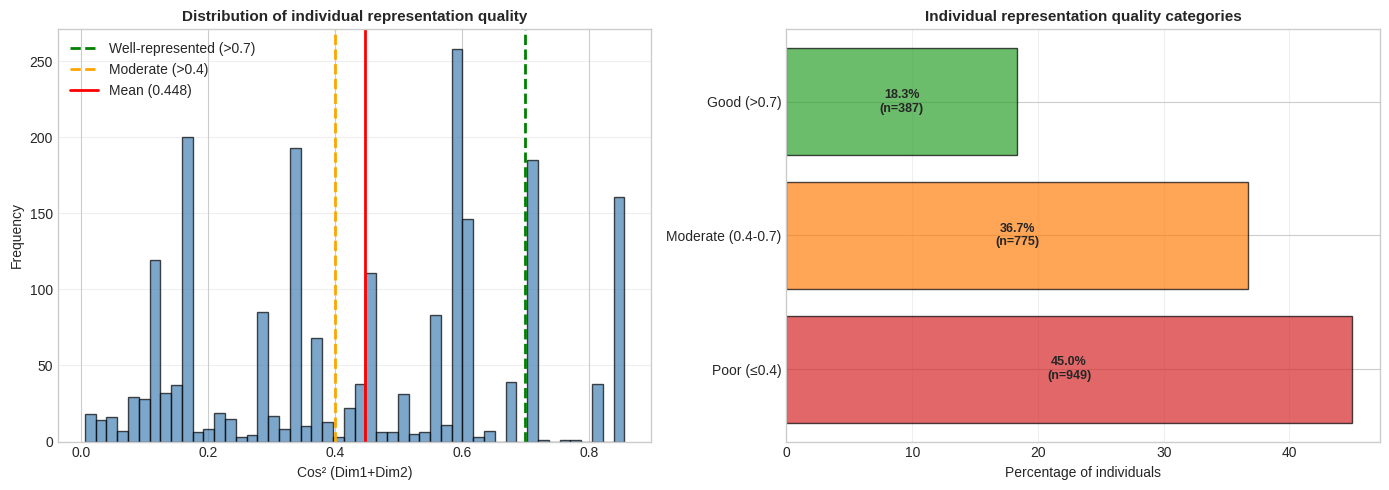

In [14]:
# Individuals quality of representation visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of cos² (Dim1+Dim2)
ax1.hist(individual_cos2_sum, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
ax1.axvline(
    x=0.7, color="green", linestyle="--", linewidth=2, label="Well-represented (>0.7)"
)
ax1.axvline(x=0.4, color="orange", linestyle="--", linewidth=2, label="Moderate (>0.4)")
ax1.axvline(
    x=individual_cos2_sum.mean(),
    color="red",
    linestyle="-",
    linewidth=2,
    label=f"Mean ({individual_cos2_sum.mean():.3f})",
)
ax1.set_xlabel("Cos² (Dim1+Dim2)", fontsize=10)
ax1.set_ylabel("Frequency", fontsize=10)
ax1.set_title(
    "Distribution of individual representation quality", fontsize=11, fontweight="bold"
)
ax1.legend()
ax1.grid(axis="y", alpha=0.3)

# Stacked bar for quality categories
quality_cats = ["Poor (≤0.4)", "Moderate (0.4-0.7)", "Good (>0.7)"]
quality_counts = [poor_count, moderate_count, well_count]
quality_pcts = [c / len(individual_cos2_sum) * 100 for c in quality_counts]
colors = ["#d62728", "#ff7f0e", "#2ca02c"]

ax2.barh(quality_cats, quality_pcts, color=colors, alpha=0.7, edgecolor="black")
for i, (cat, pct, cnt) in enumerate(zip(quality_cats, quality_pcts, quality_counts)):
    ax2.text(
        pct / 2,
        i,
        f"{pct:.1f}%\n(n={cnt})",
        ha="center",
        va="center",
        fontsize=9,
        fontweight="bold",
    )
ax2.set_xlabel("Percentage of individuals", fontsize=10)
ax2.set_title(
    "Individual representation quality categories", fontsize=11, fontweight="bold"
)
ax2.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig("approach1_individuals_quality.png", dpi=300, bbox_inches="tight")
plt.show()

In [15]:
# Individuals contributions calculation
n_obs = X_mca.shape[0]
mass = np.ones(n_obs) / n_obs

# Calculate contributions to dimensions 1 and 2
contrib_dim1 = (mass * X_mca[:, 0] ** 2) / mca.explained_variance_[0] * 100
contrib_dim2 = (mass * X_mca[:, 1] ** 2) / mca.explained_variance_[1] * 100

# Convert to Series for easier manipulation
contrib_dim1_series = pd.Series(contrib_dim1)
contrib_dim2_series = pd.Series(contrib_dim2)

# Summary statistics
print("\nIndividuals contributions summary:")
print(
    f"  Dim1 - Mean: {contrib_dim1.mean():.4f}%, Median: {np.median(contrib_dim1):.4f}%"
)
print(
    f"  Dim2 - Mean: {contrib_dim2.mean():.4f}%, Median: {np.median(contrib_dim2):.4f}%"
)
print(
    f"  Top 10 individuals contribute {contrib_dim1_series.nlargest(10).sum():.2f}% to Dim1"
)
print(
    f"  Top 10 individuals contribute {contrib_dim2_series.nlargest(10).sum():.2f}% to Dim2"
)


Individuals contributions summary:
  Dim1 - Mean: 0.0401%, Median: 0.0238%
  Dim2 - Mean: 0.0419%, Median: 0.0210%
  Top 10 individuals contribute 3.21% to Dim1
  Top 10 individuals contribute 3.95% to Dim2


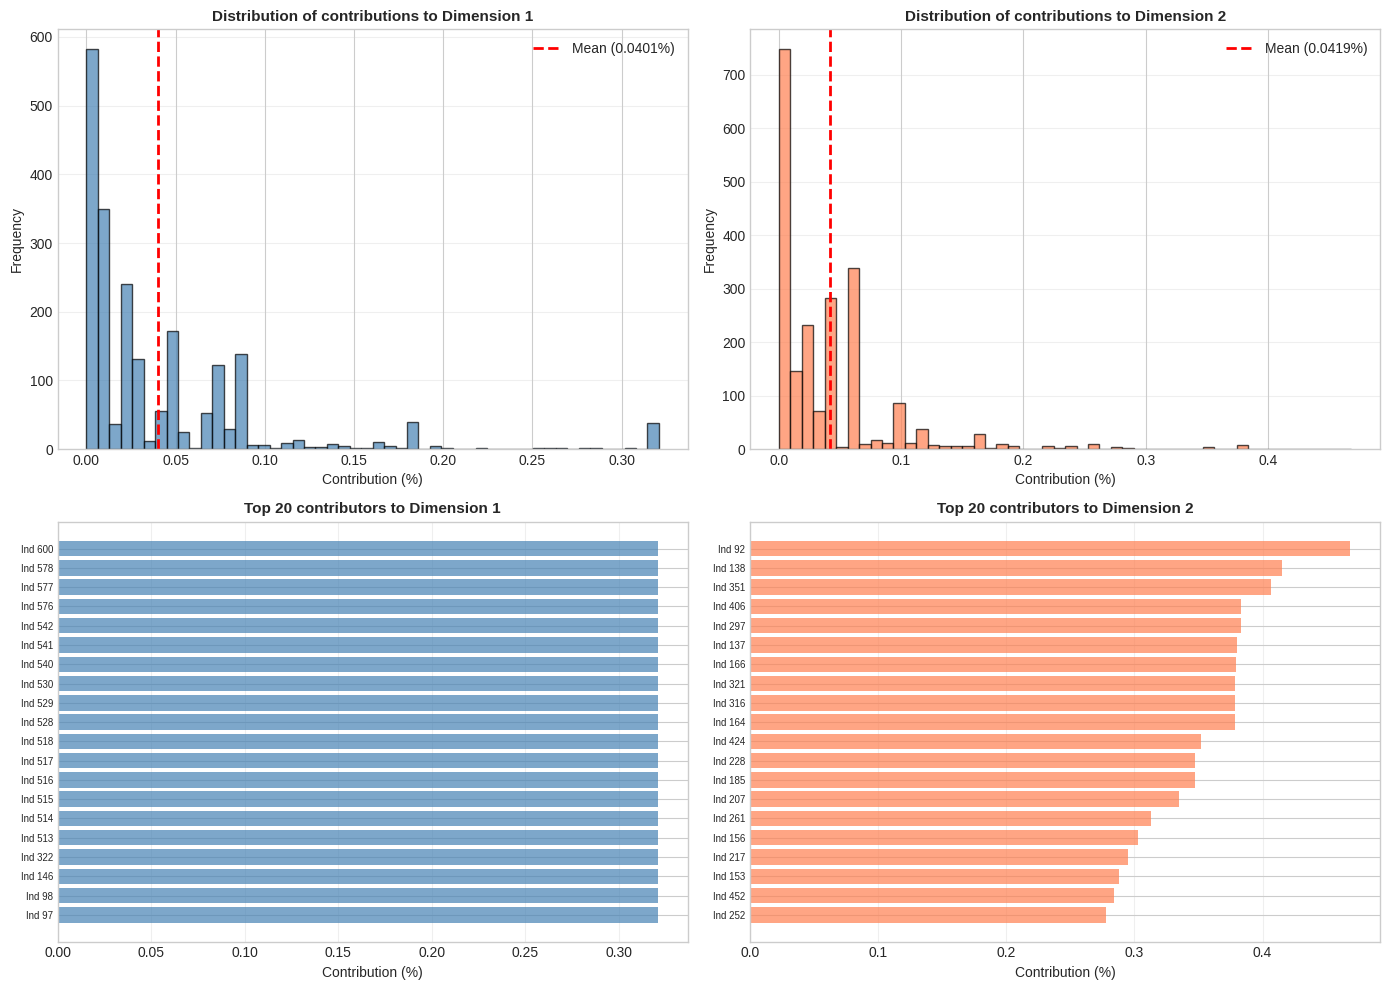

In [16]:
# Individuals contribution visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram Dim1
axes[0, 0].hist(contrib_dim1, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
axes[0, 0].axvline(
    x=contrib_dim1.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean ({contrib_dim1.mean():.4f}%)",
)
axes[0, 0].set_xlabel("Contribution (%)", fontsize=10)
axes[0, 0].set_ylabel("Frequency", fontsize=10)
axes[0, 0].set_title(
    "Distribution of contributions to Dimension 1", fontsize=11, fontweight="bold"
)
axes[0, 0].legend()
axes[0, 0].grid(axis="y", alpha=0.3)

# Histogram Dim2
axes[0, 1].hist(contrib_dim2, bins=50, color="coral", alpha=0.7, edgecolor="black")
axes[0, 1].axvline(
    x=contrib_dim2.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean ({contrib_dim2.mean():.4f}%)",
)
axes[0, 1].set_xlabel("Contribution (%)", fontsize=10)
axes[0, 1].set_ylabel("Frequency", fontsize=10)
axes[0, 1].set_title(
    "Distribution of contributions to Dimension 2", fontsize=11, fontweight="bold"
)
axes[0, 1].legend()
axes[0, 1].grid(axis="y", alpha=0.3)

# Top 20 contributors to Dim1
top20_dim1 = contrib_dim1_series.nlargest(20).sort_values()
axes[1, 0].barh(range(20), top20_dim1.values, color="steelblue", alpha=0.7)
axes[1, 0].set_yticks(range(20))
axes[1, 0].set_yticklabels([f"Ind {i}" for i in top20_dim1.index], fontsize=7)
axes[1, 0].set_xlabel("Contribution (%)", fontsize=10)
axes[1, 0].set_title(
    "Top 20 contributors to Dimension 1", fontsize=11, fontweight="bold"
)
axes[1, 0].grid(axis="x", alpha=0.3)

# Top 20 contributors to Dim2
top20_dim2 = contrib_dim2_series.nlargest(20).sort_values()
axes[1, 1].barh(range(20), top20_dim2.values, color="coral", alpha=0.7)
axes[1, 1].set_yticks(range(20))
axes[1, 1].set_yticklabels([f"Ind {i}" for i in top20_dim2.index], fontsize=7)
axes[1, 1].set_xlabel("Contribution (%)", fontsize=10)
axes[1, 1].set_title(
    "Top 20 contributors to Dimension 2", fontsize=11, fontweight="bold"
)
axes[1, 1].grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig("approach1_individuals_contributions.png", dpi=300, bbox_inches="tight")
plt.show()

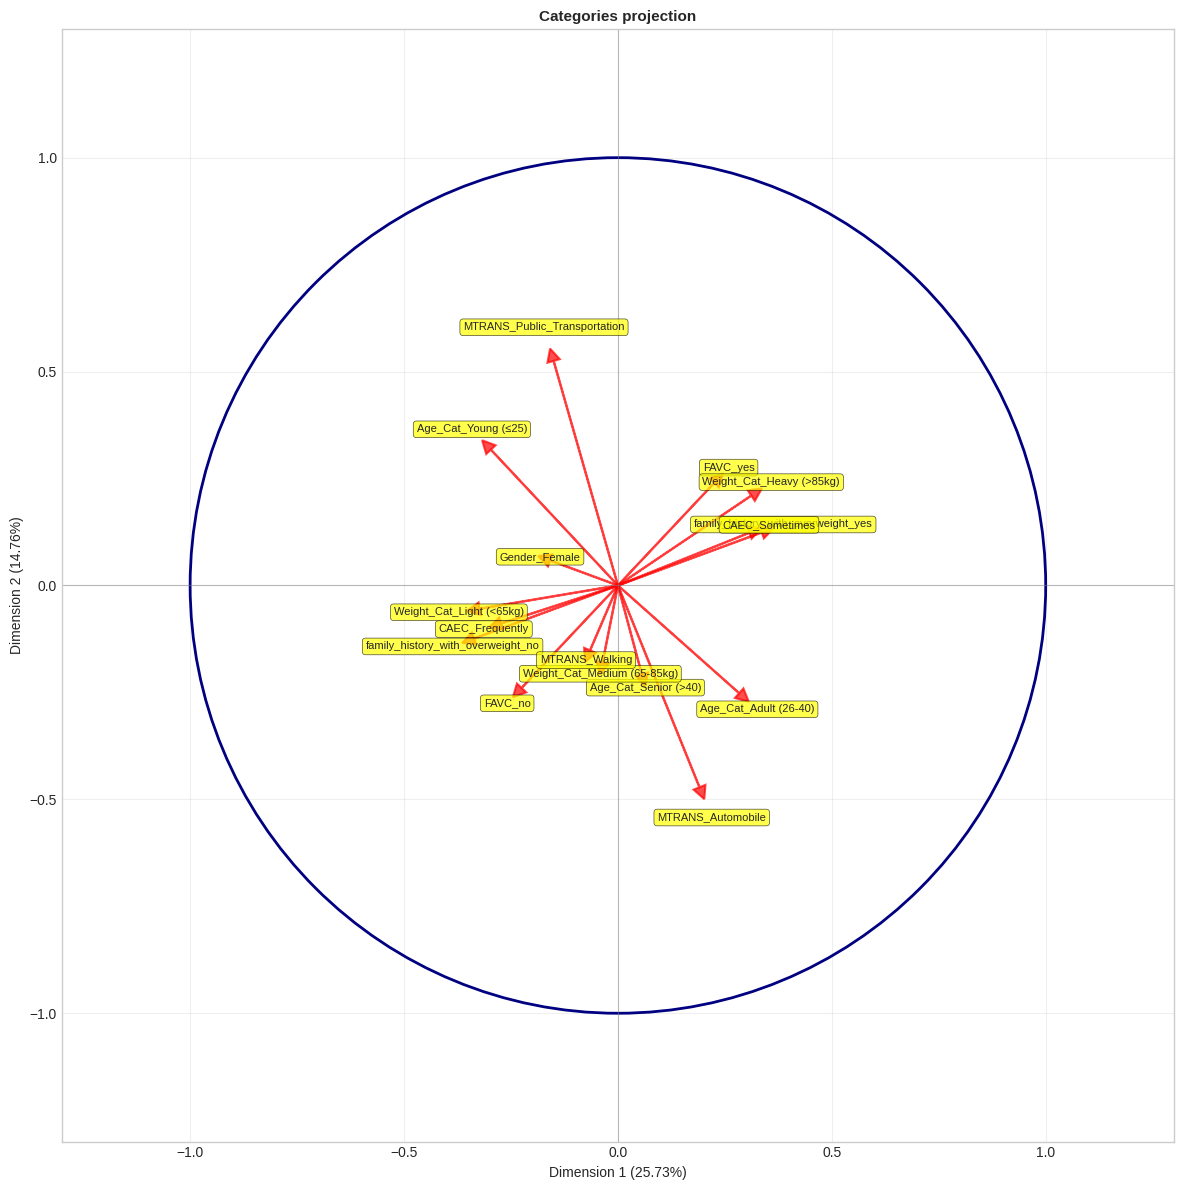

In [17]:
# Categories projection
fig, ax = plt.subplots(figsize=(12, 12))

circle = plt.Circle((0, 0), 1, color="navy", fill=False, linewidth=2)
ax.add_patch(circle)

# Select top categories
top_categories = set(
    list(contributions_df["Dim1"].abs().nlargest(12).index)
    + list(contributions_df["Dim2"].abs().nlargest(12).index)
)

for category in top_categories:
    x = contributions_df.loc[category, "Dim1"]
    y = contributions_df.loc[category, "Dim2"]
    
    ax.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, 
             fc="red", ec="red", linewidth=1.5, alpha=0.7)
    
    ax.text(x * 1.15, y * 1.15, category, fontsize=8, ha="center", va="center",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7,
                     edgecolor="black", linewidth=0.5))

ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.axhline(y=0, color="gray", linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color="gray", linewidth=0.8, alpha=0.5)
ax.set_xlabel(f"Dimension 1 ({mca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=10)
ax.set_ylabel(f"Dimension 2 ({mca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=10)
ax.set_title("Categories projection", fontsize=11, fontweight="bold")
ax.grid(alpha=0.3)
ax.set_aspect("equal")

plt.tight_layout()
plt.savefig("approach1_categories_projection.png", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
# Summary
print("\nSummary:")
print(
    f"  Total variance (first 2 dims): {mca.explained_variance_ratio_[:2].sum()*100:.2f}%"
)
print(
    f"  Total variance (first 3 dims): {mca.explained_variance_ratio_[:3].sum()*100:.2f}%"
)
print(f"  Active variables: {len(df_categorical.columns)}")
print(f"  Indicator variables: {len(df_indicators.columns)}")


Summary:
  Total variance (first 2 dims): 40.48%
  Total variance (first 3 dims): 51.95%
  Active variables: 7
  Indicator variables: 21
